# **Desafio Cientista de Dados - Indicium LightHouse**

Fui alocado em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.

<br>

**Tópicos neste notebook:**

1 - Data Description

2 - Feature Engineering

3 - Salvando dataset

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re

from IPython.display         import Image, display
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

## 0.1 Helper Function

In [2]:
# Configurações Gerais
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['figure.figsize'] = [20, 10]

## 0.2 Loading data

In [3]:
# Dataset
df_raw = pd.read_csv('../datasets/raw_datasets/teste_indicium_precificacao.csv', low_memory = False)

## 0.3 Splitting dataset

Antes de iniciar o projeto com o dataset, é importante separar os dados que recebemos em treino e teste por boa prática.

Resumidamente, sobre os datasets,

- **Treino:** será utilizado para fazer as análises (EDA) e treinar os algoritmos de machine learning (o cross validation é feito utilizando esse dataset, que é dividido em k folds...).

- **Teste:** será utilizado para verificação da performance do modelo após o treino. Recebe os mesmos tratamentos que o dataset de treino recebeu e na parte de pré-processamento rescaling/encoding, recebe apenas o transform, evitando vazamento de dados.

In [4]:
# Separando features/target
X = df_raw.drop('price', axis=1)
y = df_raw['price'].copy()

# Split Train/Test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TREINO
df0 = pd.concat([x_train, y_train], axis=1)
df0 = df0.reset_index(drop=True)

# TESTE - Salvando para usar em ML.
df_test_raw = pd.concat([x_test, y_test], axis=1)
df_test_raw = df_test_raw.reset_index(drop=True)
df_test_raw.to_csv('../datasets/raw_datasets/test_raw_from_split_train.csv', index=False)

# **1.0 Data Description**

In [5]:
df1 = df0.copy()

| COLUNA                         | DESCRIÇÃO                                                                             |
|--------------------------------|---------------------------------------------------------------------------------------|
| id                             | Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo                |
| nome                           | Representa o nome do anúncio                                                         |
| host_id                        | Representa o id do usuário que hospedou o anúncio                                     |
| host_name                      | Contém o nome do usuário que hospedou o anúncio                                       |
| bairro_group                   | Contém o nome do bairro onde o anúncio está localizado                                |
| bairro                         | Contém o nome da área onde o anúncio está localizado                                  |
| latitude                       | Contém a latitude do local                                                           |
| longitude                      | Contém a longitude do local                                                          |
| room_type                      | Contém o tipo de espaço de cada anúncio                                               |
| price                          | Contém o preço por noite em dólares listado pelo anfitrião                            |
| minimo_noites                  | Contém o número mínimo de noites que o usuário deve reservar                          |
| numero_de_reviews              | Contém o número de comentários dados a cada listagem                                   |
| ultima_review                  | Contém a data da última revisão dada à listagem                                        |
| reviews_por_mes                | Contém o número de avaliações fornecidas por mês                                       |
| calculado_host_listings_count  | Contém a quantidade de listagem por host                                               |
| disponibilidade_365            | Contém o número de dias em que o anúncio está disponível para reserva                   |


## 1.1 Rename Columns

In [6]:
df1.columns
df1['bairro_group'].unique()
df1.rename(columns={'bairro_group': 'distrito', 'calculado_host_listings_count': 'host_total_listings'}, inplace=True)

## 1.2 Data Dimension

In [7]:
# Printando linhas/colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

# Para estas dimensões do dataset, podemos continuar sem a necessidade de uma Cloud para o processamento dos dados.

Number of Rows: 39115
Number of Cols: 16


## 1.3 Data Types

In [8]:
df1.dtypes

id                       int64
nome                    object
host_id                  int64
host_name               object
distrito                object
bairro                  object
latitude               float64
longitude              float64
room_type               object
minimo_noites            int64
numero_de_reviews        int64
ultima_review           object
reviews_por_mes        float64
host_total_listings      int64
disponibilidade_365      int64
price                    int64
dtype: object

## 1.4. Check NA

In [9]:
'''
Existem 3 opções para tratar os NAs

1- Descartar linhas com valores ausentes (NA):
    Vantagem: rápido e fácil.
    Desvantagem (significativa): Pode levar à perda de informações importantes e prejudicar a performance do modelo se o conjunto de dados for pequeno.

2- Utilizar algoritmos de Machine Learning:
    Existem métodos para preencher valores ausentes (NA) que se baseiam no comportamento das colunas.
    Podemos utilizar métodos estatísticos como a média ou mediana, ou algorimos de Machine Learning para prever valores ausentes.
    Essa técnica é útil quando não se tem informações de negócio.

3- Entender a lógica de negócio:
    Compreendendo a lógica de negócio, é possível identificar o motivo dos valores ausentes e estabelecer regras para preenchê-los.  

Utilizarei a opção 3 para preencher os valores faltantes (NA) no próximo tópico.
'''

df1.isna().sum()

id                        0
nome                     10
host_id                   0
host_name                19
distrito                  0
bairro                    0
latitude                  0
longitude                 0
room_type                 0
minimo_noites             0
numero_de_reviews         0
ultima_review          8070
reviews_por_mes        8070
host_total_listings       0
disponibilidade_365       0
price                     0
dtype: int64

## 1.5 Fillout NA

In [10]:
# Coluna host_name preencida com NI (Não informado)
df1['host_name'] = df1['host_name'].fillna('NI')

# Coluna nome preencida com NI (Não informado)
df1['nome'] = df1['nome'].fillna('NI')

# Coluna ultima_review preenchida com data muito no passado/futuro
df1['ultima_review'] = df1['ultima_review'].fillna('1900-01-01')

# Coluna reviews_por_mes preenchida com 0 - (pelo visto, é a média das reviews, mas por mês, resultando em valores decimais)
# Se Nan, adicionei 0, pois não possui review alguma, nota-se a coluna ultima_review com a mesma quantidade de NAN.
df1['reviews_por_mes'] = df1['reviews_por_mes'].fillna(0)

# Verificação da remoção dos NaN
df1.isna().sum()

#2019-01-03

id                     0
nome                   0
host_id                0
host_name              0
distrito               0
bairro                 0
latitude               0
longitude              0
room_type              0
minimo_noites          0
numero_de_reviews      0
ultima_review          0
reviews_por_mes        0
host_total_listings    0
disponibilidade_365    0
price                  0
dtype: int64

## 1.6 Change Types

In [11]:
# Verificando os tipos de dados novamente após as alterações feitas no tópico 1.5, por boa prática.  
df1.dtypes

# Covertendo para data
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])
df1.dtypes

id                              int64
nome                           object
host_id                         int64
host_name                      object
distrito                       object
bairro                         object
latitude                      float64
longitude                     float64
room_type                      object
minimo_noites                   int64
numero_de_reviews               int64
ultima_review          datetime64[ns]
reviews_por_mes               float64
host_total_listings             int64
disponibilidade_365             int64
price                           int64
dtype: object

## 1.7 Removendo Duplicadas

In [12]:
# Supondo que 'df' seja o seu DataFrame
num_duplicatas = df1.duplicated().sum()
print("Número de linhas duplicadas:", num_duplicatas)

Número de linhas duplicadas: 0


## 1.8 Estatística Descritiva (Primeira impressão dos dados)

In [13]:
'''
Utilidade da estatística descritiva aqui:

1- Ganhar conhecimento de negócio.

2- Conseguir detectar alguns erros.
    Exemplo: preços com valores negativos.
'''

# Separando variáveis numéricas e categóricas 
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.8.1 Vars Numéricas

In [14]:
# Criando tabela de estatística descritiva
aux1 = num_attributes.describe().T

# Complementando a tabela do .describe()
funcoes = ['min', 'max', 'ptp', 'skew', 'kurt']

# Usei agg() para aplicar todas essas funções de uma vez
aux2 = num_attributes.agg(funcoes).T
aux2.columns = ['Min', 'Max', 'Range', 'Skew', 'Kurtosis']
aux2

# Concatenando os datasets para melhor visualização
stats_table = pd.concat([aux1, aux2], axis=1)
stats_table = stats_table.drop(['count', 'Max', 'Min'], axis=1)
stats_table = stats_table.drop(['id', 'host_id'], axis=0)
stats_table

,mean,std,min,25%,50%,75%,max,Range,Skew,Kurtosis
latitude,40.73,0.05,40.50,40.69,40.72,40.76,40.91,0.41,0.23,0.13
longitude,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71,0.53,1.29,5.09
minimo_noites,7.03,19.99,1.00,1.00,3.00,5.00,1000.00,999.00,20.66,756.07
numero_de_reviews,23.26,44.43,0.00,1.00,5.00,24.00,629.00,629.00,3.69,19.70
reviews_por_mes,1.09,1.60,0.00,0.04,0.37,1.59,58.50,58.50,3.53,51.95
host_total_listings,7.11,32.77,1.00,1.00,1.00,2.00,327.00,326.00,7.96,68.04
disponibilidade_365,112.93,131.73,0.00,0.00,45.00,227.00,365.00,365.00,0.76,-1.00
price,153.77,244.16,0.00,69.00,106.00,176.00,10000.00,10000.00,18.21,528.58


Na tabela, nota-se uma incoerencia, existe valor mínimo 0 no preço, o que não faz sentido. Logo abaixo, indetifico que são apenas 9 valores zerados, então decide removê-los, uma vez que o dataset possui 39115 linhas, não fará diferença. Achei essa atitude melhor, pois eu poderia usar a média da coluna preço para preenhcer esses valores zerados, mas eu poderia, talvez, criar imóveis com preços de alugueis distorcidos, o que poderia prejudicar meu modelo de machine learning.

In [15]:
# Identificando total de linhas com preço zero
price_0 = df1[df1['price'] == 0].shape[0]
print(f'Total de preços zerados: {price_0} removidos')

# Removedo colunas de preço 0
df1 = df1[df1['price'] != 0]
df1 = df1.reset_index(drop=True)

Total de preços zerados: 9 removidos


### 1.8.2 Vars Categóricas

In [16]:
# Verificando a quantidade de valores únicos de cada coluna categórica
cat_unicos = cat_attributes.apply(lambda x: x.unique().shape[0])
cat_unicos

nome         38444
host_name    10029
distrito         5
bairro         218
room_type        3
dtype: int64

In [17]:
# Porcentagem dos distritos em relação ao dataset, Manhattan está presente em 45% do dataset
df1['distrito'].value_counts(normalize=True).head()

distrito
Manhattan       0.45
Brooklyn        0.41
Queens          0.12
Bronx           0.02
Staten Island   0.01
Name: proportion, dtype: float64

In [18]:
# Porcentagem dos bairros em relação ao dataset
df1['bairro'].value_counts(normalize=True)

bairro
Williamsburg                 0.08
Bedford-Stuyvesant           0.08
Harlem                       0.05
Bushwick                     0.05
Upper West Side              0.04
                             ... 
Woodrow                      0.00
Bay Terrace, Staten Island   0.00
West Farms                   0.00
Rossville                    0.00
Richmondtown                 0.00
Name: proportion, Length: 218, dtype: float64

In [19]:
# Porcentagem dos tipos de quartos/salas em relação ao dataset
df1['room_type'].value_counts(normalize=True).head()

room_type
Entire home/apt   0.52
Private room      0.46
Shared room       0.02
Name: proportion, dtype: float64

# **2.0 Feature Engineering**

Feature engineering é o processo de criar/transformar variáveis para melhorar o desempenho dos modelos de machine learning. Isso é feito para ajudar os algoritmos de aprendizado de máquina a entenderem melhor os padrões nos dados, tornando as características mais significativas e relevantes para o problema em questão. O objetivo é melhorar a precisão, a generalização e a performance dos modelos de machine learning.

In [20]:
df2 = df1.copy()

## **2.1 MindMap de Hipóteses**

O Mindmap de Hipóteses nos ajuda a criar hipóteses sobre o fenômeno estudado. Tais hipóteses geradas serão investigadas na EDA (Análise Exploratória de Dados).

Na imagem abaixo encontra-se o Mindmap de hipóteses, onde ao centro, o 'Preço do Aluguel Temporário' é o fenômeno a ser investigado e está rodeado por suas entidades, seguidas por seus atributos.

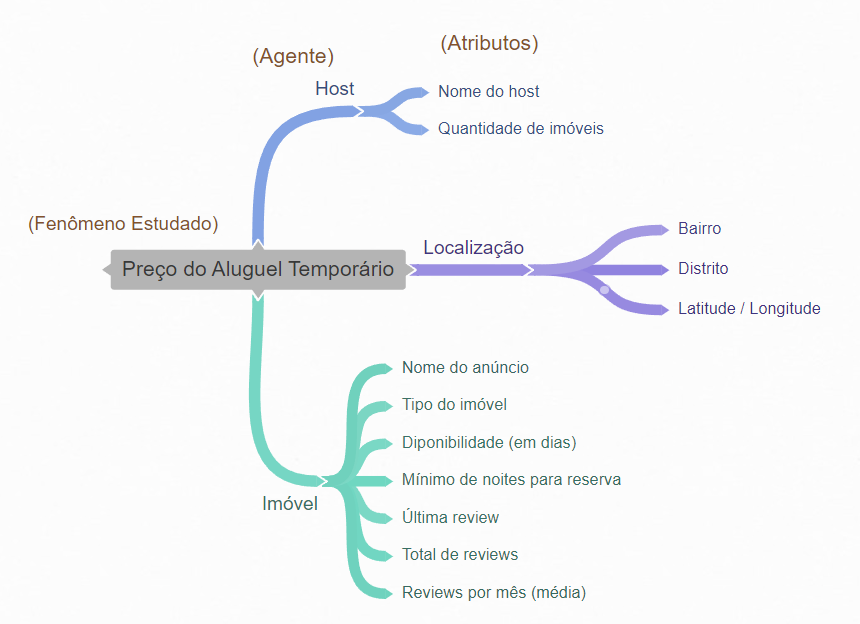

In [21]:
Image('../images/mindmap.png')

NOTA: No cotidiano de uma empresa, as etapas iniciais são compostas por:

1- Investigação individual: Nesta fase, eu, como profissional responsável pelo projeto, realizo investigações e análises preliminares, criando incialmente meu próprio mindmap.

2- Após a investigação inicial, compartilho minhas descobertas com a área de negócio, onde os stakeholders avaliam e contribuem com suas perspectivas e ideias.

3- Com base nas ideias reunidas tanto por mim quanto pela área de negócio, a equipe técnica e de análise de dados entra em ação. Juntos, verificamos quais dados estão disponíveis no banco de dados para implementar as ideias discutidas anteriormente.

Obs.: Os atributos com asterisco não estão presentes no dataset, mas é interessante investigar, pois pode contribuir para entender mais sobre o problema de negócio e talvez melhorar a performance do modelo de machine learning.

## **2.2 Criação de Hipóteses**

### 2.2.1 Hipóteses sobre o Imóvel

**1.** Aluguéis de espaço inteiro ('Entire home/apt') possuem preços maiores.

**2.** Imóveis com maiores diponibilidade em dias, possuem preços menores.

**3.** Um 'mínimo de noites' para reserva de 1 dia, possui preços menores dentre os mínimos 7, 15 e 30 dias.

**4.** Imóveis com mais reviews, possuem preços menores.

**5.** Imóveis com as maiores reviews por mês, possuem preços menores.

### 2.2.2 Hipóteses sobre Localização

**1.** Aluguéis em Manhattan possuem o maior preço dentre os distritos de New York.

**2.** Imóveis com localização próxima ao mar, possuem preços mais caros.

### 2.2.3 Hipóteses do Host

**1.** Hosts que possuem mais imóveis, possuem um preço maior.

----

## **2.3 Lista Final de Hipóteses**

**1.** Aluguéis de espaço inteiro ('Entire home/apt') possuem preços maiores.

**2.** Imóveis com maiores disponibilidade em dias, possuem preços menores.

**3.**  Um 'mínimo de noites' para reserva de 1 dia, possui preços menores dentre os mínimos 7, 15 e 30 dias.

**4.** Imóveis com mais reviews, possuem preços menores.

**5.** Imóveis com as maiores reviews por mês, possuem preços menores.

**6.** Aluguéis em Manhattan possuem o maior preço dentre os distritos de New York.

**7.** Imóveis com localização próxima ao mar, possuem preços mais caros.

**8.** Hosts que possuem mais imóveis, possuem um preço maior.

## **2.4 Feature Engineering**

In [22]:
# FEATURE: ano, mês, dia 
# Objetivo: verificar se há sazonalidades nos meses, anos e dias.
df2['ano'] = df2['ultima_review'].dt.year
df2['mes'] = df2['ultima_review'].dt.month
df2['dia'] = df2['ultima_review'].dt.day


# FEATURE: recencia das reviews 
# Objetivo: verificar quantos dias se passaram desde a última review (quanto maior o valor de dias, pior, considerando que, se houve review, é porque ocorreu uma hospedagem/negócio)
# Nota: Valores na 'dias_desde_ultima_review' de 43652 referem-se as datas de 1900-01-01, utilizadas para o preenchimento de NAN na coluna 'ultima_review'.
ultima_data = df2['ultima_review'].max()
df2['dias_desde_ultima_review'] = (ultima_data - df2['ultima_review']).dt.days


# FEATURE: quantidade possível máxima de se alugar o imóvel por ano, considerando apenas o mínimo de noites
# Objetivo: identificar a flexibilidade de aluguel do imóvel
# Nota: se o mínimo de noites for maior 365 dias, só pode ser alugado uma vez por ano ou menos. 
df2['qnt_alug_possiv_por_ano'] =  365 / df2['minimo_noites'] 


# FEATURE: desempenho do quão requisitado foi o imóvel durante o ano
# Objetivo: verificar o desempenho através da disponibilidade_365 (dias restantes)
# Nota: quanto mais próximo de zero, melhor para o imóvel, pois mostra que foi bem requisitado, talvez influenciando no preço. 
#       Por exemplo: 365 dias do ano - 65 dias disponiveis = 300 dias alugados, logo o imóvel foi bem requisitado.
df2['dias_alugados'] = df2['disponibilidade_365'].apply(lambda x: (365 - x) if x > 0 and x <= 364 else x) # else x, para casos como, disponibilidade365 = 365 ou 0.


# FEATURE: peso dos preços dos distritos
# Objetivo: identificar distritos mais caros
# Nota: Ordenei a feature de acordo com os valores das medianas vistas no boxplot da hipótese 6.
mapeamento_distrito_peso = {
    'Bronx': 1,
    'Queens': 2,
    'Staten Island': 3,
    'Brooklyn': 4,
    'Manhattan': 5}

df2['distrito_peso'] = df2['distrito'].map(mapeamento_distrito_peso)

Uma boa feature pode melhorar consideravelmente o desempenho do modelo. Boas features aumentam mais a performance do modelo do que técnicas de Fine Tuning (mas este também é importante, desenvolverei no tópico 8).

# **3.0 Salvando dataset**

In [23]:
df2.to_csv('../datasets/cooked_datasets/df3_processed.csv', index=False)